## Bayesian rate consistency model with PriorVAE


In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
numpyro.set_host_device_count(4)
numpyro.enable_x64()

import jax
import optax
from jax import random
import jax.numpy as jnp
import pyreadr
import pandas as pd
import os
from flax import linen as nn
import arviz as az

from priorCVAE.models import MLPDecoder
from priorCVAE.priors import Matern32, Matern52, SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.utility import load_model_params

from bayes_rate_consistency.model import simulation_model_gp, simulation_model_vae
from bayes_rate_consistency.mcmc import run_mcmc
from bayes_rate_consistency.simulation import load_simulated_dataset, sim_make_mcmc_data, simulation_inference, simulation_postprocess
from bayes_rate_consistency.simulation import sim_posterior_predictive_check

import jax.config as config
config.update("jax_enable_x64", True)

In [2]:
# Configuration dictionary
args = {
        "n_data": 44,
        "batch_size": 500,
        "num_iterations": 5000,
        "data_dim": 2,

        "input_dim" : 1936,
        "hidden_dim": 80,
        "latent_dim": 30,

        "n_test": 5000,
        "kernel": "matern52",
        "ls": 0.2
       }

In [3]:
args['model_path'] = "weights/vae_1936_8000_mat52_0.2"
# args['model_path'] = "weights/vae_3000_mat52_0.4_2_2"

## Generate data

In [4]:
kernel = Matern52(lengthscale=0.2)

gp_set = GPDataset(n_data=args["n_data"], kernel=kernel, sample_lengthscale=False, x_dim=2)  
# sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=args['batch_size'])
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1)

## Load the model


In [5]:
decoder_params = load_model_params(args["model_path"])["decoder"]

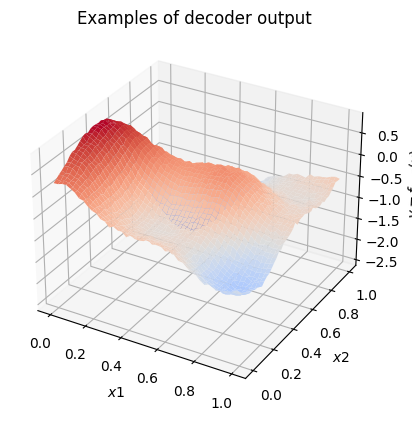

In [6]:
from priorCVAE.models import MLPDecoder
# from bayes_rate_consistency.decoder import MLPDecoder

# decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])
decoder = MLPDecoder([args["hidden_dim"], args["hidden_dim"], args["hidden_dim"]], args["input_dim"], nn.gelu)

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (args["n_test"], args["latent_dim"]))

key = jax.random.PRNGKey(rnd.randint(0, 9999))
key, e_rng, d_rng = jax.random.split(key, 3)

vae_samples = decoder.apply({'params': decoder_params}, z)             


vae_samples_reshaped = vae_samples.reshape((args["n_test"], gp_set.n_data, gp_set.n_data))

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d"})

x = jnp.linspace(0, 1, args['n_data'])
x1, x2 = jnp.meshgrid(x, x)
ax.plot_surface(x1, x2, vae_samples_reshaped[50], cmap=coolwarm)

ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()

## Bayesian rate consistency model

#### Load Data

In [7]:
A = 44 # number of ages
size = 2000
strata_scheme = 'COVIMOD'
is_covid = True


data = load_simulated_dataset(
    project_root='./',
    is_covid=is_covid,
    size=size,
    strata=strata_scheme
)

In [8]:
mcmc_data = sim_make_mcmc_data(data, strata_scheme, A)

#### Plot contact counts

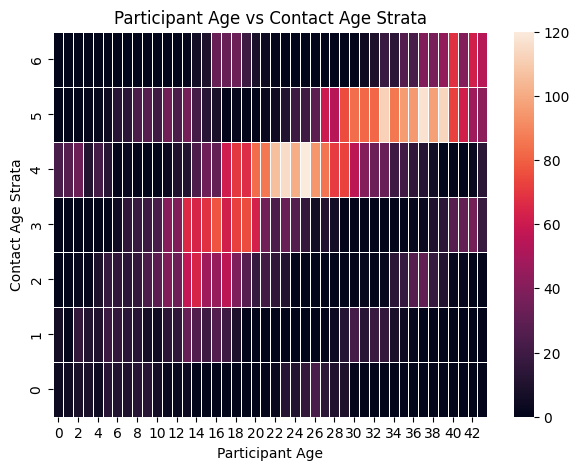

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))  # Set the figure size
sns.heatmap(mcmc_data['Y_MM'].T, annot=False, fmt="d", linewidths=.5)

plt.title('Participant Age vs Contact Age Strata')
plt.xlabel('Participant Age')
plt.ylabel('Contact Age Strata')

plt.gca().invert_yaxis()

# Display the plot
plt.show()


#### MCMC Inference

In [10]:
model = simulation_model_gp

In [11]:

args = {
        # decoder architecture
        "input_dim" : 1936,
        "hidden_dim": 80,
        "latent_dim": 30,
        "z_dim": 30,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 200,
        "num_samples": 200,
        "num_chains": 1,
        "thinning": 1,
       }

In [12]:
args['logP'] = mcmc_data['log_P_M']
args['logN'] = mcmc_data['log_N_M']

args['map_age_to_strata'] = mcmc_data['map_age_to_strata']

# 1e-13

In [13]:
args['decoder'] = decoder
args['decoder_params'] = decoder_params

In [14]:
x = gp_set.x
args['kernel'] = Matern52(0.2)(x,x)
args['size'] = x.shape[0]

In [15]:
numpyro.enable_validation()
rng_key = random.PRNGKey(1)
rng_key, rng_key_post, rng_key_predict, rng_key_draw = jax.random.split(rng_key, 4)

mcmc, mcmc_samples, t_elapsed = run_mcmc(rng_key_post, model, args, y=mcmc_data['Y_MM'])

sample: 100%|██████████| 400/400 [09:42<00:00,  1.46s/it, 1023 steps of size 5.14e-03. acc. prob=0.86]


In [16]:
predictive = Predictive(model, mcmc_samples.copy())
predictions = predictive(rng_key_predict, args)

In [17]:
inference_data = az.from_numpyro(mcmc, posterior_predictive=predictions)
# inference_data
# az.ess(inference_data.posterior, relative=True).values

In [18]:
inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [19]:
mcmc_samples['alpha'].shape

(200, 44, 7)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

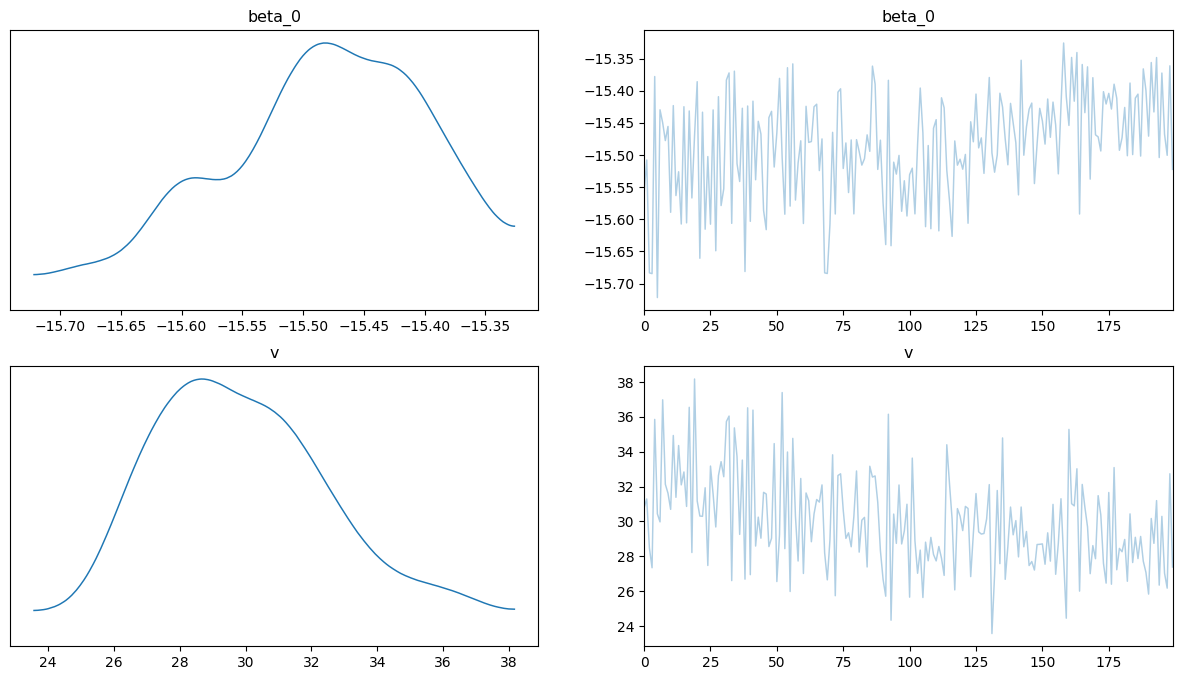

In [20]:
az.plot_trace(mcmc, var_names = ("beta_0", "v"), figsize = (15, 8), compact = False)

#### Posterior predictive checks

In [21]:
y_strata = mcmc_data['Y_MM']
y_check = sim_posterior_predictive_check(y_strata, inference_data.posterior_predictive['yhat_strata'])
print(f"Proportion of y in 95% CI: {y_check:.5f}")



Proportion of y in 95% CI: 0.95130


In [22]:
yhat_strata = inference_data.posterior_predictive.median(dim=["chain", "draw"])['yhat_strata'].values
np.mean(np.abs(yhat_strata-y_strata))

15.785714285714286

#### Recover contact intensities

In [23]:
P = mcmc_data['P_M']
P = np.tile(P, (44, 1))

m_pred = jnp.exp(inference_data.posterior_predictive.median(dim=["chain", "draw"])['log_contact_rate'].values).reshape(44,44) * P

In [24]:
m = data[
    (data['gender'] == 'Male') & 
    (data['alter_gender'] == 'Male')
].sort_values(by=['age', 'alter_age']).cntct_intensity.to_numpy().reshape(44,44)

In [25]:
mae = np.mean(np.abs(m - m_pred))
mae

0.1292609963654154

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Simulated intensities'}>)

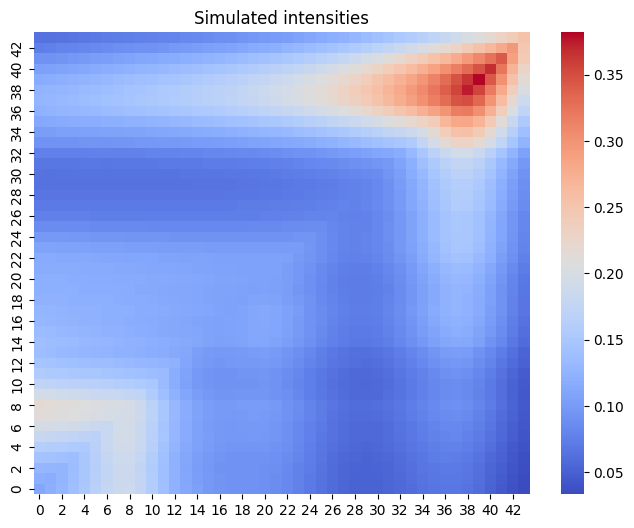

In [26]:
def plot_heatmap(matrix: jnp.ndarray, title='', figsize=(8,6)):
    """ Plot a heatmap of the input matrix. """

    # matrix[0, 42:44] = 100
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.heatmap(matrix, annot=False, fmt='g', cmap='coolwarm', ax=ax)
    ax.set_title(title)
    plt.gca().invert_yaxis()
    return fig, ax

plot_heatmap(m_pred.T, title='Simulated intensities')

In [27]:
k1 = Matern52()
kp5 = Matern52(0.5)

In [28]:
from priorCVAE.priors import Matern52
k1 = Matern52(0.4)
kp5 = Matern52(2.0)

x = jnp.linspace(0, 1, 44)

np.isnan(np.kron(k1(x,x),kp5(x,x)).T).any()

False

In [29]:
from mlkernels.jax import Matern52 as Matern52_ml
from lab import B
kx = Matern52_ml().stretch(0.4)(x, x)
ky = Matern52_ml().stretch(2.0)(x, x)
kx = B.dense(kx)
ky = B.dense(ky)
# B.dense(np.kron(kx, ky))
# B.dense(kernel(x))
# kx
jnp.kron(kx, ky).T

Array([[1.        , 0.99988735, 0.9995496 , ..., 0.05347148, 0.05305174,
        0.05262768],
       [0.99988735, 1.        , 0.99988735, ..., 0.05388663, 0.05347148,
        0.05305174],
       [0.9995496 , 0.99988735, 1.        , ..., 0.05429693, 0.05388663,
        0.05347148],
       ...,
       [0.05347148, 0.05388663, 0.05429693, ..., 1.        , 0.99988735,
        0.9995496 ],
       [0.05305174, 0.05347148, 0.05388663, ..., 0.99988735, 1.        ,
        0.99988735],
       [0.05262768, 0.05305174, 0.05347148, ..., 0.9995496 , 0.99988735,
        1.        ]], dtype=float64)